## Сравнение средних значений (дисперсионный анализ)

Мы имеем результаты двух тестов приложения по доставке готовых продуктов:

- В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
- Во втором была обновлена кнопка заказа и часть юзеров видела старый вариант, а часть – новый

Задача – проверить гипотезы о наличии различий среди тестируемых групп, сделать соответствующие выводы на основе статистических тестов и принять решения.

### Задания:

1. Выберите метод, который предположительно подойдет в первом вопросе.
2. Проверьте, являются ли дисперсии внутри групп гомогенными.
3. Проведите тест на нормальность распределения.
4. Сравните средние в представленных группах.
5. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия. 
6. Примите решение: какие картинки в итоге будем использовать?
7. Выберите метод для второго теста.
8. Визуализируйте распределение events для контрольной и тестовой групп. 
9. Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя. 
10. Выберите формулу для модели, проведите тест.

### Описание данных:

**5_task_1:**

- id – id клиента в эксперименте
- group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- events – сколько блюд суммарно было заказано за период

**5_task_2:**

- id – id клиента в эксперименте
- segment – сегмент (high/low)
- group – вид кнопки (control – старая версия, test – новая версия)
- events – сколько блюд суммарно было заказано за период

In [1]:
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)
import pingouin as pg
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Загрузим данные

In [2]:
df1 = pd.read_csv('5_task_1.csv')
df2 = pd.read_csv('5_task_2.csv')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
df1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [4]:
df2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


**Для первого теста** нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

- A – прямоугольные 16:9
- B – квадратные
- C – прямоугольные 12:4

**Задача 1:** Каким статистическим тестом нужно воспользоваться для сравнения средних в данном случае?

Так как в данном случае мы имеем дело с более чем двумя группами и хотим оценить показатели статистической значимости, используем ANOVA

**Задача 2:** Проверить, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) 

С помощью pingouin

In [5]:
pg.homoscedasticity(data=df1, dv='events', group='group')

,W,pval,equal_var
levene,2.26226,0.104133,True


С помощью теста Левена

In [6]:
group_a = df1.query('group == "A"').events
group_b = df1.query('group == "B"').events
group_c = df1.query('group == "C"').events

In [7]:
ss.levene(group_a, group_b, group_c)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

И в том и в другом случае **p-value > 0.05**, следовательно дисперсии **гомогенны**

**Задача 3:** Проведите тест на нормальность распределения.

Применим тест Шапиро-Уилка для проверки на нормальность. Перед применением критерия при проверке на нормальность сделаем семплирование (1000 наблюдений), так как на больших выборках данный тест может дать неверные результаты. Для воспроизводимости результата используем параметр random_state=17 в методе sample.

In [8]:
ss.shapiro(group_a.sample(1000, random_state=17))

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [9]:
ss.shapiro(group_b.sample(1000, random_state=17))

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

In [10]:
ss.shapiro(group_c.sample(1000, random_state=17))

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

Нулевая гипотеза теста Шапиро-Уилка состоит в том, что распределение нормальное. При отклонениях от нормальности мы её отвергаем.

В каждой группе **pvalue < 0.05**, следовательно распределение events в каждой из групп является **нормальным**

**Задача 4:** Сравните средние в представленных группах.

Для сравнения средних используем однофакторный дисперсионный анализ

In [11]:
ss.f_oneway(group_a, group_b, group_c)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

Значение статистики равно **2886**, а р-уровень значимости составил 
**0**

**Задача 5:** Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.

In [12]:
print(pairwise_tukeyhsd(df1.events, df1.group))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


В столбце reject для каждой пары групп стоит **True**, значит между группами **A-B**, **A-C**, **B-C** есть статистически значимые различия

**Задача 6:** Примите решение: какие картинки в итоге будем использовать?

In [13]:
pg.pairwise_tukey(data=df1, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


Среднее число заказанных блюд для группы B составило 37, значит будем использовать группу B – Квадратные картинки.

**Во втором эксперименте** требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

**Задача 7:** Выберите метод для второго теста.

В данном случае нам понадобится метод, который позволяет анализировать несколько групп, если у нас есть две разбивки по группам, т.е. многофакторный дисперсионный анализ

**Задача 8:** Визуализируйте распределение events для контрольной и тестовой групп.

In [14]:
df2.group.unique()

array(['test', 'control'], dtype=object)

In [15]:
df2_control = df2.query('group == "control"')
df2_test = df2.query('group == "test"')

Text(-2.575000000000003, 0.5, 'Количество наблюдений')

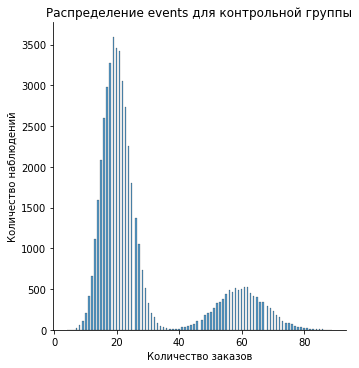

In [29]:
sns.displot(df2_control, x='events')
plt.title('Распределение events для контрольной группы')
plt.xlabel('Количество заказов')
plt.ylabel('Количество наблюдений')

Text(-2.575000000000003, 0.5, 'Количество наблюдений')

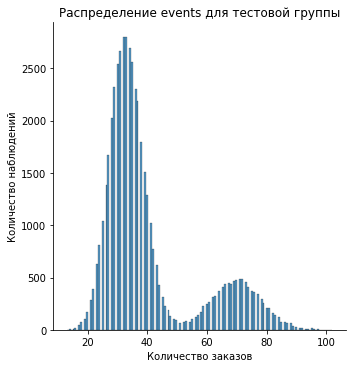

In [16]:
sns.displot(df2_test, x='events')
plt.title('Распределение events для тестовой группы')
plt.xlabel('Количество заказов')
plt.ylabel('Количество наблюдений')

**Задача 9:** Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя.

In [18]:
df2.groupby(['group', 'segment']).events.describe()

count       mean       std   min   25%   50%   75%    max
group   segment                                                             
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

Среднее число заказов в тестовой группе в high сегменте выросло на 10 по сравнению с контрольной группой, в low сегменте - на 13 заказов.

**Задача 10:** Выберите формулу для модели, проведите тест.

Для проверки влияния эффекта нескольких переменных - group и segment, на зависимой переменной events, с взаимодействием факторов, выберем следующую формулу для модели:
**events ~ segment + group + segment:group** 



In [19]:
pg.anova(data=df2, dv='events', between=['group', 'segment'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


Проведем тест через anova_lm, а затем используем критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

В данном случае для последующих сравнений между группами можно проделать следующую операцию: соединить колонки group и segment в combination, чтобы потом передать в аргумент groups в pairwise_tukey

In [20]:
model_main = smf.ols("events ~ group + segment + group:segment", data=df2).fit()
anova_lm(model_main, typ=2)

,sum_sq,df,F,PR(>F)
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group:segment,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [21]:
df2['combination'] = df2.group.astype('str') + ' / ' + df2.segment.astype('str')

In [22]:
df2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test / high
1,96723,test,high,71.0,test / high
2,68719,test,high,80.0,test / high
3,50399,test,high,80.0,test / high
4,95613,test,high,78.0,test / high


In [23]:
pg.pairwise_tukey(data=df2, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control,test,28.01942,40.40844,-12.38902,0.10409,-119.021936,0.001,-0.752755


In [24]:
pg.pairwise_tukey(data=df2, dv='events', between='segment')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,high,low,64.95465,26.52875,38.4259,0.067541,568.923864,0.001,4.497704


In [25]:
pg.pairwise_tukey(data=df2, dv='events', between='combination')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,control / high,control / low,59.970800,20.031575,39.939225,0.065432,610.391461,0.001,6.824282
1,control / high,test / high,59.970800,69.938500,-9.967700,0.082766,-120.432523,0.001,-1.703109
2,control / high,test / low,59.970800,33.025925,26.944875,0.065432,411.798717,0.001,4.603981
3,control / low,test / high,20.031575,69.938500,-49.906925,0.065432,-762.727892,0.001,-8.527429
4,control / low,test / low,20.031575,33.025925,-12.994350,0.041383,-314.002699,0.001,-2.220314
5,test / high,test / low,69.938500,33.025925,36.912575,0.065432,564.135148,0.001,6.307128


In [26]:
print(pairwise_tukeyhsd(df2.events, df2.combination))

        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2    meandiff p-adj  lower    upper   reject
--------------------------------------------------------------------
control / high control / low -39.9392 0.001 -40.1073 -39.7711   True
control / high   test / high   9.9677 0.001   9.7551  10.1803   True
control / high    test / low -26.9449 0.001  -27.113 -26.7768   True
 control / low   test / high  49.9069 0.001  49.7388   50.075   True
 control / low    test / low  12.9944 0.001   12.888  13.1007   True
   test / high    test / low -36.9126 0.001 -37.0807 -36.7445   True
--------------------------------------------------------------------


Для обоих сегментов показатели статистически значимо **увеличились** по сравнению с контрольной группой.

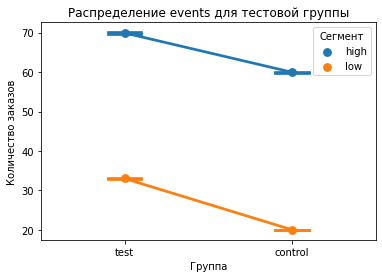

In [28]:
sns.pointplot(x="group", y="events", hue="segment", data=df2, capsize=.2)
plt.title('Распределение events для тестовой группы')
plt.xlabel('Группа')
plt.ylabel('Количество заказов')
plt.legend(title = 'Сегмент')

Фактор group оказался **значимым**, фактор segment – **значим**,
их взаимодействие – **значимо**. Судя по графику, для всех групп среднее значение events **увеличилось**.

Решение - **выкатываем новую версию**